# Project 3 Predictive analytics: model evaluation and selection

## Step 0: Set up the environment and Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [21]:
import os
import pandas as pd
import numpy as np
import scipy.io as scio
from matplotlib import pyplot as plt
import seaborn as sns
import time
from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.externals import joblib
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import xgboost
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.io import loadmat
import scipy

## Step 1: Feature Extraction

In [4]:
class load():
    def load_data(filename):
        raw_data = pd.read_csv(filename)
        raw_data['filename'] = [str(i).zfill(4)+'.jpg' for i in raw_data['Index'].tolist()]
        raw_data['pointsname'] = [str(i).zfill(4)+'.mat' for i in raw_data['Index'].tolist()]
        return raw_data

    #read points data from mat data
    def load_points(points_path,data):
        n = data.shape[0]
        points_data = np.zeros([n,3003,2])
        start_time = time.time()
        for i in range(n):
            result = loadmat(points_path+data['pointsname'][i])
            key = sorted(result.keys())[-1]
            points = result[key]
            distance_h = []
            distance_v = []
            for d in range(points.shape[0]-1):
                for j in range(d+1,points.shape[0]):
                    distance_h.append(abs(points[d,0]-points[j,0]))
                    distance_v.append(abs(points[d,1]-points[j,1]))

            points_data[i,:,0]=distance_h
            points_data[i,:,1]=distance_v
        print("--- %s seconds ---" % (time.time() - start_time))
        return points_data.reshape([2500,6006])

<font color='blue'> Please modify the path in the following part to get different files.</font>


In [5]:
path = '/Users/zhaoziqin/Desktop/train_set/'  # Please modify your own path
data = load.load_data(path+'label.csv')
points_path = '/Users/zhaoziqin/Desktop/train_set/points/'
X = load.load_points(points_path,data)
X = np.round(X,0)
y= data['emotion_idx'].to_numpy()

--- 13.732297897338867 seconds ---


## Step 2 : Train-Test Split

In [6]:
train_x,test_x,train_y,test_y=train_test_split(X,y,test_size=0.2,random_state=123)

In [7]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(2000, 6006)
(500, 6006)
(2000,)
(500,)


## Step 3 : Baseline Model --- GBM

We used Cross-Validation to find the more efficient estimator combination for baseline model and fitted by using this combination.

In [8]:
start_time = time.time()
baseline = GradientBoostingClassifier(n_estimators=100,max_depth= 1,learning_rate=0.1)
gbm_model = baseline.fit(train_x,train_y) 
print("--- %s seconds ---" % (time.time() - start_time))

--- 521.2786290645599 seconds ---


In [9]:
baseline_train_accuracy = gbm_model.score(train_x,train_y)
baseline_test_accuracy = gbm_model.score(test_x,test_y)
print("Training Accuracy on the baseline model: %.4f" % (baseline_train_accuracy))
print("Testing Accuracy on the baseline model: %.4f" % (baseline_test_accuracy))

baseline_pred_train = gbm_model.predict(train_x)
t1 = time.time()
baseline_pred_test = gbm_model.predict(test_x)
print("Prediction on Baseline: %s seconds" % (time.time() - t1))

print(classification_report(train_y, baseline_pred_train))
print(classification_report(test_y, baseline_pred_test))


Training Accuracy on the baseline model: 0.8380
Testing Accuracy on the baseline model: 0.3820
Prediction on Baseline: 0.035868167877197266 seconds
              precision    recall  f1-score   support

           1       0.87      0.97      0.91        94
           2       0.93      0.99      0.96        95
           3       0.80      0.90      0.85       110
           4       0.80      0.82      0.81        97
           5       0.90      0.95      0.92        91
           6       0.81      0.83      0.82        78
           7       0.88      0.88      0.88        94
           8       0.94      0.95      0.95       104
           9       0.91      0.95      0.93        84
          10       0.79      0.77      0.78        87
          11       0.89      0.82      0.85        99
          12       0.85      0.75      0.79        80
          13       0.81      0.65      0.72        83
          14       0.78      0.90      0.84        99
          15       0.86      0.77      0.

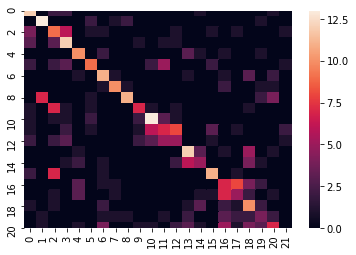

In [49]:
cm_baseline = confusion_matrix(test_y,baseline_pred_test)
sns.heatmap(cm_baseline)

## Step 4 : Candidate Advanced Model --- Part I

For our advanced model, we chose different models to fit the train dataset. Here is the following models we picked as our candidate advanced models firstly.

 1. XGBoost
 2. Logistic Regression
 3. Support Vector Machine (SVM)
 4. LDA
 5. Random Forest
 
For each of these models, We have different python files for each model which contains the completed process. In each of model, we used Cross-Validation to find the best parameter combination and fit the training set.

### 1. XGBoost

#### We used  GridSearch cross-validation to find the best parameter combination.
'max_depth': range (1, 5, 1)

'n_estimators': range(1, 200, 20)

'learning_rate': [0.1, 0.01, 0.05]

Results: Best Max Depth: 2 / Best N.estimators: 181 / Best Learning Rate: 0.1

In [11]:
start_time = time.time()
xgb = XGBClassifier(n_estimators = 181,max_depth=2,learning_rate=0.1)
xgb_model = xgb.fit(train_x,train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 1987.00168800354 seconds ---


In [13]:
xgb_train_accuracy = xgb_model.score(train_x,train_y)
xgb_test_accuracy = xgb_model.score(test_x,test_y)
print("Training Accuracy on the xgb model: %.4f" % (xgb_train_accuracy))
print("Testing Accuracy on the xgb model: %.4f" % (xgb_test_accuracy))

xgb_pred_train = xgb_model.predict(train_x)
t1 = time.time()
xgb_pred_test = xgb_model.predict(test_x)
print("Prediction on XGBoost: %s seconds" % (time.time() - t1))

print(classification_report(train_y, xgb_pred_train))
print(classification_report(test_y, xgb_pred_test))


Training Accuracy on the xgb model: 1.0000
Testing Accuracy on the xgb model: 0.4920
Prediction on XGBoost: 1.1762139797210693 seconds
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00        95
           3       1.00      1.00      1.00       110
           4       1.00      1.00      1.00        97
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        94
           8       1.00      1.00      1.00       104
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00        87
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        83
          14       1.00      1.00      1.00        99
          15       1.00      1.00      1.00        73


### 2. Logistic Regression

#### We used GridSearchCV to fine the best parameter combination
'C': [0.001,0.01, 1, 25,50,100] 

Result:

 'C': 0.01,
 'dual': False.
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 300,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'lbfgs',
 'tol': 0.0001}

In [14]:
start_time = time.time() 
lr = LogisticRegression(C=0.01, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=300,
                   multi_class='multinomial', penalty='l2',
                   solver='lbfgs', tol=0.0001)
lr_model = lr.fit(train_x,train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 14.355353116989136 seconds ---


In [15]:
lr_train_accuracy = lr_model.score(train_x,train_y)
lr_test_accuracy = lr_model.score(test_x,test_y)
print("Training Accuracy on the logistic regression model: %.4f" % (lr_train_accuracy))
print("Testing Accuracy on the logistic regression model: %.4f" % (lr_test_accuracy))

lr_pred_train = lr_model.predict(train_x)
t1 = time.time()
lr_pred_test = lr_model.predict(test_x)
print("Prediction on Logistic Regression: %s seconds" % (time.time() - t1))

print(classification_report(train_y, lr_pred_train))
print(classification_report(test_y, lr_pred_test))

Training Accuracy on the logistic regression model: 0.7725
Testing Accuracy on the logistic regression model: 0.5140
Prediction on Logistic Regression: 0.008421897888183594 seconds
              precision    recall  f1-score   support

           1       0.84      0.89      0.87        94
           2       0.93      0.94      0.93        95
           3       0.83      0.85      0.84       110
           4       0.76      0.76      0.76        97
           5       0.85      0.89      0.87        91
           6       0.77      0.77      0.77        78
           7       0.80      0.79      0.80        94
           8       0.93      0.95      0.94       104
           9       0.92      0.93      0.92        84
          10       0.67      0.64      0.66        87
          11       0.81      0.81      0.81        99
          12       0.68      0.66      0.67        80
          13       0.64      0.64      0.64        83
          14       0.77      0.83      0.80        99
        

### 3. Support Vector Machine (SVM)

#### We used GridSearchCV to find the best parameter combination of SVM.
param= {'C': [0.0000001,0.000001,0.00001,0.0001,0.001,0.01,1]}

Result: 'C':0.00001

In [18]:
start_time = time.time()
svc = SVC(kernel= 'linear', random_state = 123, C = 0.00001)
svm = svc.fit(train_x,train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 18.18335795402527 seconds ---


In [20]:
svm_train_accuracy = svm.score(train_x,train_y)
svm_test_accuracy = svm.score(test_x,test_y)
print("Training Accuracy on the logistic regression model: %.4f" % (svm_train_accuracy))
print("Testing Accuracy on the logistic regression model: %.4f" % (svm_test_accuracy))

svm_pred_train = svm.predict(train_x)
t1 = time.time()
svm_pred_test = svm.predict(test_x)
print("Prediction on SVM: %s seconds" % (time.time() - t1))

print(classification_report(train_y, svm_pred_train))
print(classification_report(test_y, svm_pred_test))

Training Accuracy on the logistic regression model: 0.8145
Testing Accuracy on the logistic regression model: 0.4840
Prediction on SVM: 5.256656885147095 seconds
              precision    recall  f1-score   support

           1       0.88      0.97      0.92        94
           2       0.96      0.96      0.96        95
           3       0.87      0.82      0.85       110
           4       0.75      0.81      0.78        97
           5       0.90      0.95      0.92        91
           6       0.79      0.78      0.79        78
           7       0.87      0.87      0.87        94
           8       0.94      0.98      0.96       104
           9       0.93      0.95      0.94        84
          10       0.70      0.79      0.74        87
          11       0.86      0.76      0.81        99
          12       0.66      0.71      0.69        80
          13       0.65      0.61      0.63        83
          14       0.75      0.89      0.81        99
          15       0.85    

### 4. Linear Discriminant Analysis (LDA)

In [29]:
start_time = time.time()
lda = LDA(solver='eigen', shrinkage=.1, n_components=2)
lda_model = lda.fit(train_x, train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 68.76783013343811 seconds ---


In [26]:
lda_train_accuracy = lda_model.score(train_x,train_y)
lda_test_accuracy = lda_model.score(test_x,test_y)
print("Training Accuracy on the LDA model: %.4f" % (lda_train_accuracy))
print("Testing Accuracy on the LDA model: %.4f" % (lda_test_accuracy))

lda_pred_train = lda_model.predict(train_x)
t1 = time.time()
lda_pred_test = lda_model.predict(test_x)
print("Prediction on LDA: %s seconds" % (time.time() - t1))

print(classification_report(train_y, lda_pred_train))
print(classification_report(test_y, lda_pred_test))

Training Accuracy on the LDA model: 0.8580
Testing Accuracy on the LDA model: 0.5380
Prediction on LDA: 0.007727146148681641 seconds
              precision    recall  f1-score   support

           1       0.91      0.99      0.95        94
           2       0.93      0.96      0.94        95
           3       0.87      0.89      0.88       110
           4       0.86      0.84      0.85        97
           5       0.96      0.90      0.93        91
           6       0.84      0.82      0.83        78
           7       0.90      0.87      0.89        94
           8       0.95      0.92      0.94       104
           9       0.94      0.96      0.95        84
          10       0.75      0.86      0.80        87
          11       0.96      0.70      0.81        99
          12       0.79      0.82      0.80        80
          13       0.75      0.81      0.78        83
          14       0.84      0.86      0.85        99
          15       0.88      0.77      0.82        73
  

### 5. Random Forest

In [28]:
start_time = time.time()
rf = RandomForestClassifier(n_estimators = 100, criterion = 'gini', min_samples_leaf=1, max_features='sqrt')
rf_model = rf.fit(train_x, train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 7.890650987625122 seconds ---


In [30]:
rf_train_accuracy = rf_model.score(train_x,train_y)
rf_test_accuracy = rf_model.score(test_x,test_y)
print("Training Accuracy on the random forest model: %.4f" % (rf_train_accuracy))
print("Testing Accuracy on the random forest model: %.4f" % (rf_test_accuracy))

rf_pred_train = rf_model.predict(train_x)
t1 = time.time()
rf_pred_test = rf_model.predict(test_x)
print("Prediction on Random Forest: %s seconds" % (time.time() - t1))

print(classification_report(train_y, rf_pred_train))
print(classification_report(test_y, rf_pred_test))

Training Accuracy on the random forest model: 1.0000
Testing Accuracy on the random forest model: 0.4040
Prediction on Random Forest: 0.040242910385131836 seconds
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        94
           2       1.00      1.00      1.00        95
           3       1.00      1.00      1.00       110
           4       1.00      1.00      1.00        97
           5       1.00      1.00      1.00        91
           6       1.00      1.00      1.00        78
           7       1.00      1.00      1.00        94
           8       1.00      1.00      1.00       104
           9       1.00      1.00      1.00        84
          10       1.00      1.00      1.00        87
          11       1.00      1.00      1.00        99
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        83
          14       1.00      1.00      1.00        99
          15       1.00   

## Step 5: 
## Ensemle with VotingClassifier : Combining the effective models to get the better prediction

#### From our candidate advanced models 1-5, summary is in the following :

In [65]:
chart = {'Candidate Model':['Baseline(GBM)', 'XGBoost', 'Logistic Regression', 'LDA','SVM','Random Forest'],
         'Training Accuracy(%)':['83.8','100','77.25','85.8','81.45','100'],
        'Testing Accuracy(%)':['38.2','49.2','51.4','53.8','48.4','40.4'],
         'Fitting Time':['521s','1987s','15s','68.77s','18.18s','7.9s'],
         'Prediction Time':['0.036s','1.18s','0.0084s','0.0077s','5.26s','0.04s']
        }

df = pd.DataFrame(chart,index = ['1','2','3','4','5','6'])
df

,Candidate Model,Training Accuracy(%),Testing Accuracy(%),Fitting Time,Prediction Time
1,Baseline(GBM),83.8,38.2,521s,0.036s
2,XGBoost,100,49.2,1987s,1.18s
3,Logistic Regression,77.25,51.4,15s,0.0084s
4,LDA,85.8,53.8,68.77s,0.0077s
5,SVM,81.45,48.4,18.18s,5.26s
6,Random Forest,100,40.4,7.9s,0.04s


Now, we want to combine the effiective models showing above and to do a ensemble prediction. 

From all the candidate models, XGBoost, Logistic Regression, LDA and SVM have the higher testing accuracy. 
At the same time, XGBoost has the longer fitting time, so we did not pick XGBoost in our ensemble model.

#### Ensemble : Logistic Regression, LDA and SVM

In [47]:
start_time = time.time()
eclf = VotingClassifier(
    estimators=[('lr', lr), ('lda', lda), ('svm', svc)], 
    voting='hard',
    weights=[1.5,1.5,1])
eclf_model = eclf.fit(train_x, train_y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 105.66939377784729 seconds ---


In [60]:
eclf_train_accuracy = eclf_model.score(train_x,train_y)
eclf_test_accuracy = eclf_model.score(test_x,test_y)
print("Training Accuracy on the Ensemle model: %.4f" % (eclf_train_accuracy))
print("Testing Accuracy on the Ensemle model: %.4f" % (eclf_test_accuracy))

eclf_pred_train = eclf_model.predict(train_x)
t1 = time.time()
eclf_pred_test = eclf_model.predict(test_x)
print("Prediction on Ensemle model: %s seconds" % (time.time() - t1))

Training Accuracy on the Ensemle model: 0.8405
Testing Accuracy on the Ensemle model: 0.5460
Prediction on Ensemle model: 6.695195913314819 seconds


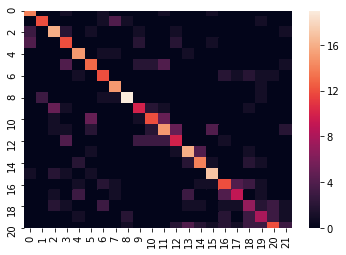

In [53]:
cm_eclf = confusion_matrix(test_y,eclf_pred_test)
sns.heatmap(cm_eclf)

## Step 6 : Candidate Advanced Model --- Deep Learning

### Neutral Network 

At the beginning of this model, install the required packages

In [31]:
conda install keras

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [32]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [33]:
import tensorflow
import keras
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from keras import initializers
from keras.optimizers import Adam
from keras.utils import to_categorical

Using TensorFlow backend.


##### Model Fitting

In [34]:
Y = to_categorical(y)
Y = Y[:,1:]
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=1106)

In [35]:
input_shape = [6006] 
input_layer = Input(input_shape)
x = BatchNormalization(momentum = 0.88)(input_layer) 
x = Dense(22*10,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x) 
x = Dense(22*8,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*4,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
x = Dropout(0.25)(x)
x = Dense(22*2,activation='relu',kernel_initializer=initializers.glorot_normal(seed=6))(x)
output_layer = Dense(22,activation='softmax',kernel_initializer=initializers.glorot_normal(seed=6))(x) 
model = Model(input_layer,output_layer)

In [36]:
start_time = time.time()
model.compile(loss='categorical_crossentropy',optimizer = Adam(lr=0.001),metrics=['accuracy'])
model_nn = model.fit(X_train,y_train,epochs=200)
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 1/200
2000/2000 [==============================] - 13s 7ms/step - loss: 3.0633 - accuracy: 0.0810
Epoch 2/200
2000/2000 [==============================] - 5s 2ms/step - loss: 2.6660 - accuracy: 0.1675
Epoch 3/200
2000/2000 [==============================] - 5s 3ms/step - loss: 2.3384 - accuracy: 0.2355
Epoch 4/200
2000/2000 [==============================] - 5s 3ms/step - loss: 2.0736 - accuracy: 0.2975
Epoch 5/200
2000/2000 [==============================] - 6s 3ms/step - loss: 1.9892 - accuracy: 0.3215
Epoch 6/200
2000/2000 [==============================] - 5s 3ms/step - loss: 1.9165 - accuracy: 0.3560
Epoch 7/200
2000/2000 [==============================] - 5s 3ms/step - loss: 1.8152 - accuracy: 0.3890
Epoch 8/200
2000/2000 [==============================] - 5s 2ms/step - loss: 1.7222 - accuracy: 0.4080
Epoch 9/200
2000/2000 [==============================] - 5s 2ms/step - loss: 1.6400 - accuracy: 0.4460
Epoch 10/200
2000/2000 [==============================] - 5s 3ms/step - 

2000/2000 [==============================] - 5s 2ms/step - loss: 0.2133 - accuracy: 0.9215
Epoch 158/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2442 - accuracy: 0.9215
Epoch 159/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2293 - accuracy: 0.9255
Epoch 160/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2144 - accuracy: 0.9325
Epoch 161/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2005 - accuracy: 0.9345
Epoch 162/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2006 - accuracy: 0.9365
Epoch 163/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.1952 - accuracy: 0.9380
Epoch 164/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2049 - accuracy: 0.9375
Epoch 165/200
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2096 - accuracy: 0.9365
Epoch 166/200
2000/2000 [==============================] - 4s 2ms/ste

Text(0.5, 1.0, 'Accuracy Curves')

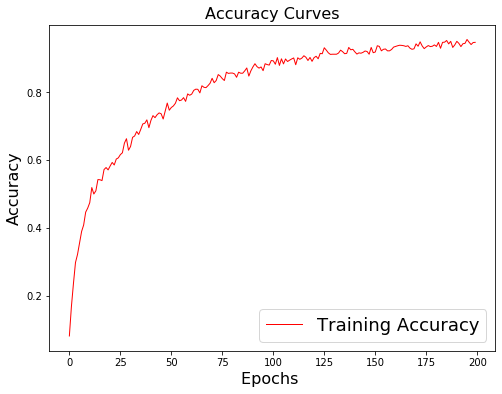

In [37]:
plt.figure(figsize=[8,6])
plt.plot(model_nn.history['accuracy'],'r',linewidth=1.0)
plt.legend(['Training Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [39]:
start_time = time.time()
pred = model.predict(X_test)
pred_list = [] 
for i in range(len(pred)):
    arr = pred[i]
    idx = np.argwhere(arr == np.max(arr))
    pred_list.append(idx[0][0])
tst_labl = np.argmax(y_test, axis=-1)
accuracy = accuracy_score(pred_list, tst_labl)
print("Test accuracy is %s percent" % round(accuracy*100,3))
print("testing model takes %s seconds" % (time.time() - start_time))

Test accuracy is 54.6 percent
testing model takes 0.35124802589416504 seconds


### Comparing : Ensemble Model VS Neutral Network

In [64]:
compare = {'Candidate Model':['Ensemble Model','Neutral Network'],
        'Testing Accuracy(%)':['54.6','55'],
         'Fitting Time':['106s','994s'],
         'Prediction Time':['6.7s','0.35s']}
df_c = pd.DataFrame(compare,index = ['1','2'])
df_c

,Candidate Model,Testing Accuracy(%),Fitting Time,Prediction Time
1,Ensemble Model,54.6,106s,6.7s
2,Neutral Network,55,994s,0.35s


In [67]:
# save ensemble model
joblib.dump(eclf,'../output/eclf.m')

['../output/eclf.m']

In [68]:
# save nn model
joblib.dump(model_nn,'../output/nn.m')

['../output/nn.m']

## Step 7 : Advanced Model (Final)